# Complex biophysical models in NeuroDyn

## Overview

In the **NeuroDyn Python model** notebook we have seen how we can define Hodgkin-Huxley and NeuroDyn models, how to simulate them, as well as how to fit the parameters of the NeuroDyn model in order to replicate the biophysical data of the squid giant axon.

Although the forms of the NeuroDyn currents are fixed to the forms of the three currents of the original Hodgkin-Huxley paper, the chip offers full flexibility in defining the dynamics of the gating variables, as well as changing the conductance parameters such as maximal conductances and reversal potentials. This flexibility allows us to use the NeuroDyn equations to replicate different types of neurons. This notebook provides an introduction to understanding how more complex biological neurons can be replicated within the NeuroDyn architecture.

We start with a biological motivation, by considering the famous model of a bursting neuron Aplysia R-15 and how its dynamical structure leads to the generation of bursts of spikes. Next, we try to mimick this basic dynamical structure using purely an interconnection of Hodgkin-Huxley models. By using the fitting techniques shown in the previous notebook, this technique can be explored to design interconnections of NeuroDyn neurons that would showcase more complex dynamical behaviors such as neuronal bursting and post-inhibitory rebound.

## Neuronal bursting

Bursting is one of the fundamental signalling modes of neurons and is ubiquitous in many different types of neurons and neural networks. Importantly, generating a burst of spikes after a hyperpolarizing current pulse is a crucial mechanism for the generation of intrinsic rhythms in half-center oscillators, which themselves are the building blocks of more complex central pattern generating networks.

<div>
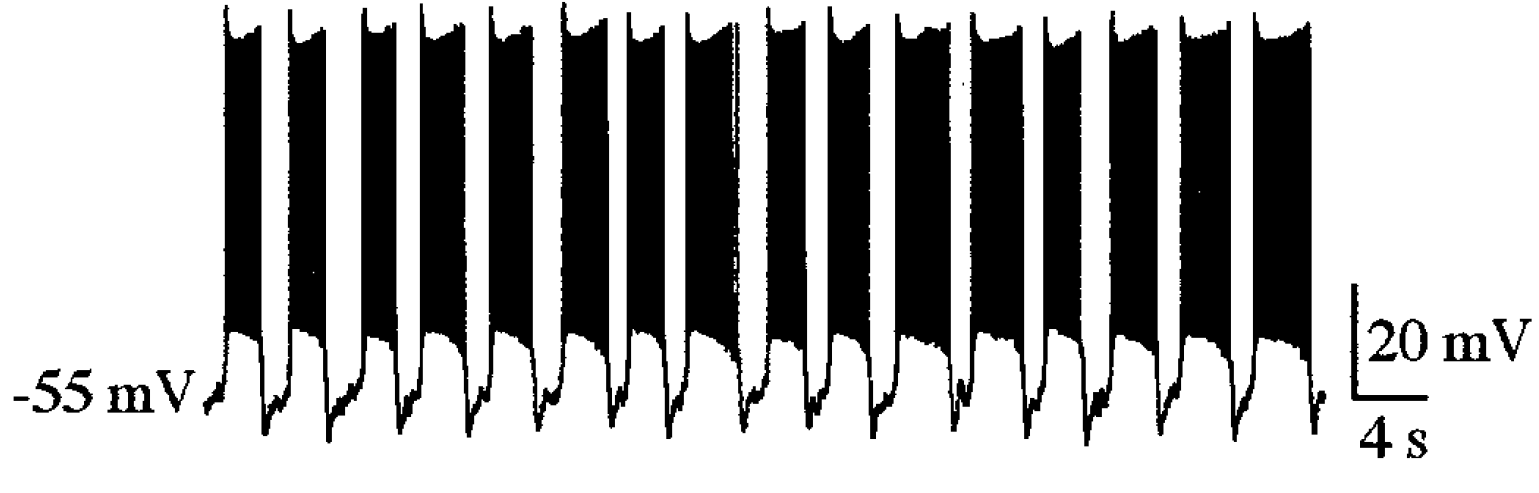
<caption><center> <b>Fig. 1: </b>Bursting in subthalamic nucleus neuron (<i>Beurrier, 1999</i>) </center></caption>
</div>


Intrinsic generation of bursts of spikes stems from the interplay of fast processes that generate individual spikes and the slower processes that modulate the spiking behavior and define the burst duration.

We have seen in the previous notebook how NeuroDyn can be set up to replicate the spiking behavior of the Hodgkin-Huxley model. In contrast, bursting models of neurons are generally more complex, consisting of several additional ionic currents that modulate the slower burst-generating process. These currents are mostly calcium-dependent and act to initiate and terminate the fast spike-generating processes dictated by the sodium and potassium currents.

Since we cannot add additional ionic currents to a single NeuroDyn neuron, we can achieve a similar affect by *interconnecting* several NeuroDyn neurons through resistive connections or short circuits.

To motivate this, let's first look at an example model of bursting and understand how the slower currents compare to the faster currents of the Hodgkin-Huxley model.

### Example model (Aplysia R-15)

As an example, let's take a look at the Aplysia R-15 bursting neuronal model, a well-studied bursting neuron. The membrane equation has five ionic currents: the leak, sodium and potassium currents that are common to the Hodgkin-Huxley model, and in addition, an inward calcium current and an outward calcium-activated potassium current. The calcium current is slower than the potassium current and its activation has an *excitatory* effect, while the calcium-activated potassium current is significantly slower than this and has an *inhibitory* effect.

The calcium and the calcium-activated potassium can be thought of as playing the roles of the standard sodium and potassium currents respectively, but in a *slower* timescale. This way, we can think of these currents being responsible for *slow excitability*, i.e. the generation of slow spikes, in contrast to the Hodgkin-Huxley currents, which generate fast spikes and therefore give rise to the *fast excitability*.

This **fast + slow** structure is what we aim to recreate through the interconnection of basic Hodgkin-Huxley or NeuroDyn blocks.

Let's take a look at the model to get a clearer picture of this. The membrane equation has the following form:

\begin{equation}
C\frac{dV}{dt} = - I_l - I_{Na} - I_K - I_{Ca} - I_{K-Ca} + I_{app},
\end{equation}

The Hodgkin-Huxley currents have the same forms as previously discussed, while the two additional currents $I_{Ca}$ and $I_{K-Ca}$ are modelled as:

\begin{align}
\label{eq:calcium}
I_{Ca} &= \bar{g}_{Ca} \, x (V - E_{Ca})\\
\label{eq:calcium_activated_potassium}
I_{K-Ca} &= \bar{g}_{K-Ca} \, \frac{c}{0.5 + c} (V - E_K)
\end{align}

The calcium activation variable $x$ and the calcium concentration $c$ have the first-order dynamics:

\begin{align}
\label{eq:xdot}
\tau_x \dot{x} &= x_{\infty}(V) - x \\
\label{eq:cdot}
\tau_{c}\dot{c} &= (K_c x (E_{Ca} - V) - c)
\end{align}

First, let's check the time plot of the membrane equation to see how the neuron behaves with the default parameters:

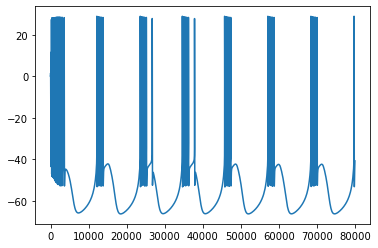

In [1]:
# Aplysia R-15 neuronal model
import matplotlib.pyplot as plt
import numpy as np
np.seterr(all="ignore")
from scipy.integrate import solve_ivp

# Alpha activation function for variable x
def alphafun(V, x):
    if (x == 'm'):
        V = np.asarray(V)
        y = np.zeros(V.shape)
        y[V != 50] = 0.1 * (50 - V) / (np.exp((50 - V)/10) - 1)
        y[V == 50] = 1
        
    if (x == 'h'):
        y = 0.07 * np.exp((25-V)/20)
    
    if (x == 'n'):
        V = np.asarray(V)
        y = np.zeros(V.shape)
        y[V != 55] = 0.01 * (55 - V) / (np.exp((55 - V)/10) - 1)
        y[V == 55] = 0.1
            
    return y

# Beta activation function for variable x
def betafun(V, x):
    if (x == 'm'):
        y = 4 * np.exp((25-V)/18)

    if (x == 'h'):
        y = 1 / (np.exp((55-V)/10) + 1)

    if (x == 'n'):
        y = 0.125 * np.exp((45-V)/80)
    
    return y

# x_inf(V) function for variable 'x'
def x_inf(V, x):
    # Define constants for gating variable 'x'
    A = 0.15
    B = -50

    # Shifted voltage constants
    C1 = 127 / 105
    C2 = 8265 / 105
    
    # Constant for Ca dynamics
    Kc = 0.0085
    
    if (x == 'x'):
        y = 1 / (np.exp(A * (B - V)) + 1)
    elif(x == 'c'):
        c = (Kc / (np.exp(A * (B - V)) + 1)) * (Eca - V)
        y = c / (0.5 + c)
    else:
        V = C1*V + C2
        y = alphafun(V,x) / (alphafun(V,x) + betafun(V,x))
    
    return y

# tau(V) function for variable 'x'
def tau(V, x):  
    # Shifted voltage constants
    C1 = 127 / 105
    C2 = 8265 / 105
    
    V = np.asarray(V)
    
    if (x == 'x'):
        y = np.ones(V.shape) * 235
    elif (x == 'c'):
        y = np.ones(V.shape) * 1 / 0.003
    else:
        # If x == 'n' or x == 'h'
        V = C1*V + C2
        y = 12.5 / (alphafun(V,x) + betafun(V,x)) # includes *1/lambda = 12.5
    
    return y

# Calcium dynamics constants
rho = 0.0003
Kc = 0.0085

# Maximum conductances in mmho/ cm^2
gna = 4
gk = 0.3
gca = 0.004
gkca = 0.03
gl = 0.003

# Nernst potentials in mV
# Note: resting potential != 0mV, not normalized as in Hodgkin-Huxley
Ena = 30
Ek = -75
Eca = 140
El = -40

# Constant current stimulus (in uA / cm^2)
I0 = 0

def Iapp(t):
    return I0

# Length of simulation (in ms)
T = 80*1000
t = (0, T)

# Initial state x = [V0, h0, n0, x0, c0]
y0 = np.array([0, 0, 0, 0, 0])

# Dynamics of the model
def ode(t, y):
    V, h, n, x, c = y
    I = Iapp(t)
    
    dV = -gna * x_inf(V,'m')**3 * h * (V - Ena) - gca * x * (V - Eca) - (gk*n**4 + gkca * c / (0.5 + c)) * (V - Ek) -gl * (V - El) + I
    dh = (x_inf(V,'h') - h) / tau(V,'h')
    dn = (x_inf(V,'n') - n) / tau(V,'n')
    dx = (x_inf(V,'x') - x) / tau(V,'x')
    dc = rho * (Kc*x*(Eca - V) - c)
    
    dy = np.asarray([dV, dh, dn, dx, dc])
    
    return dy

# Simulate the model
sol = solve_ivp(ode, t, y0)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

As we can see, the neuron generates a bursting waveform without an external stimulus. In order to get a better idea of the underlying dynamics, let's take a look at the gating variable forms. We want to get an understanding of the qualitative differences between the two slow currents $I_{Ca}$ and $I_{K-Ca}$ compared to the faster sodium and potassium currents.

Let's first look at the steady-state functions of the gating variables (note that the $I_{K-Ca}$ has a different form to other currents, but we can analyze it in a similar way).

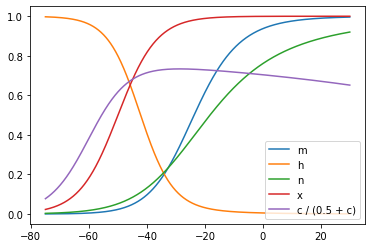

In [2]:
V = np.arange(Ek, Ena, 0.1)

plt.figure()
plt.plot(V, x_inf(V, 'm'), label='m')
plt.plot(V, x_inf(V, 'h'), label='h')
plt.plot(V, x_inf(V, 'n'), label='n')
plt.plot(V, x_inf(V, 'x'), label='x')
plt.plot(V, x_inf(V, 'c'), label='c / (0.5 + c)')

plt.legend(loc = 'lower right')
plt.show()

Notice that the activation of the calcium current $x$, and the activation of the calcium-activated potassium current $\frac{c}{0.5+c}$ activate at a lower voltage compared to the activation of sodium $m$ and activation of potassium $n$. Let's take a look at this seperately by comparing the activation of sodium with calcium, and potassium with calcium-activated potassium:

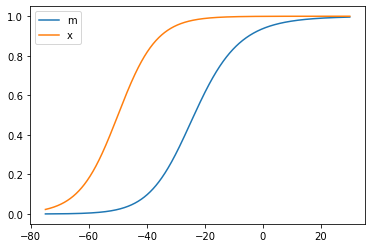

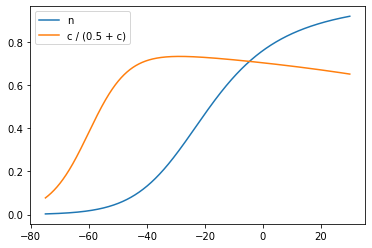

In [3]:
plt.figure()
plt.plot(V, x_inf(V, 'm'), label='m')
plt.plot(V, x_inf(V, 'x'), label='x')
plt.legend()

plt.figure()
plt.plot(V, x_inf(V, 'n'), label='n')
plt.plot(V, x_inf(V, 'c'), label='c / (0.5 + c)')
plt.legend()

plt.show()

We can see that both slow gating variables activate at *lower* voltages than the faster gating variables of sodium and potassium. This ensures that the threshold of the slow spiking is lower than the threshold of the fast spiking.

Now, let's take a look at the time-constants of the gating variables. We can plot the time-constant functions on a log scale for a clearer overview:

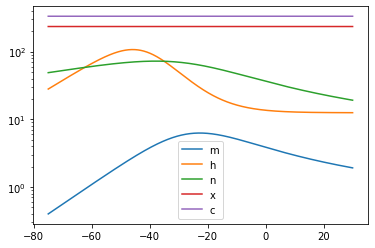

In [4]:
V = np.arange(Ek, Ena, 0.1)

plt.figure()
plt.semilogy(V, tau(V, 'm'), label='m')
plt.semilogy(V, tau(V, 'h'), label='h')
plt.semilogy(V, tau(V, 'n'), label='n')
plt.semilogy(V, tau(V, 'x'), label='x')
plt.semilogy(V, tau(V, 'c'), label='c')

plt.legend()
plt.show()

We can clearly see the separation of the timescales: the activation variables of the calcium and calcium-activated potassium are significantly slower than the gating variables of the Hodgkin-Huxley currents. Let's take a look again one by one, comparing sodium with calcium, and potassium with calcium-activated potassium:

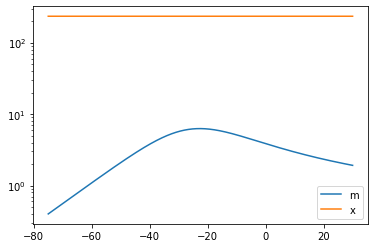

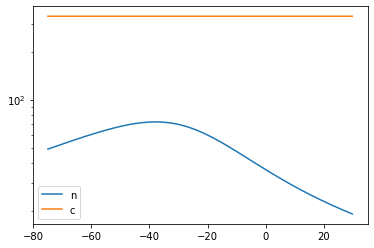

In [5]:
plt.figure()
plt.semilogy(V, tau(V, 'm'), label='m')
plt.semilogy(V, tau(V, 'x'), label='x')
plt.legend()

plt.figure()
plt.semilogy(V, tau(V, 'n'), label='n')
plt.semilogy(V, tau(V, 'c'), label='c')
plt.legend()

plt.show()

Summarizing, we can see that bursting can be achieved by adding additional currents to the Hodgkin-Huxley equation that have a similar effect as sodium and potassium, but with slower activations. These currents activate in a **lower voltage range**, ensuring that the slow threshold is below the threshold of fast spiking, and they activate on a **slower timescale**. Let's see if we can recreate this structure using only interconnections of Hodgkin-Huxley neurons, changing the parameters of the additional currents so that they retain these two important properties.

## Bursting through interconnection of Hodgkin-Huxley neurons

Let's see how we can construct a bursting neurons throgh the interconnection of Hodgkin-Huxley neurons. Similar to our biological example, we would like the first neuron to act as a standard Hodgkin-Huxley model, generating *fast excitability*. In turn, the second model needs to provide the *slow excitability*, so that the interconnection of the two will lead to the creation of bursts of spikes.

### Loading the model

First, let's load the model and the required modules:

In [28]:
import matplotlib.pyplot as plt
from cb_models_old import HHModel, NeuroDynModel, ShortCircuit

# **Ignore overflow warnings**
import numpy as np
d = np.seterr(all="ignore")

### Short-circuiting neurons

Now let's start by defining two Hodgkin-Huxley neurons and short circuiting them. We can use the class `ShortCircuit` for this, which takes a list of neurons, and short-circuits them so that the membrane voltages of all the neurons are equal. Alternatively, we can create a network of neurons and connect them with a low-resistance connections, mirroring the structure of multiple compartment models. The network class is described in the notebook **Networks in NeuroDyn**.

Let's try this out on the default Hodgkin-Huxley models first. If we interconnect two identical neurons like this, the capacitance and all maximal conductance parameters will effectively double due to the parallel interconnection of all the elements. This means that by also doubling the injected current compared to a single Hodgkin-Huxley neuron, we would expect to see the same behavior. Let's try this out:

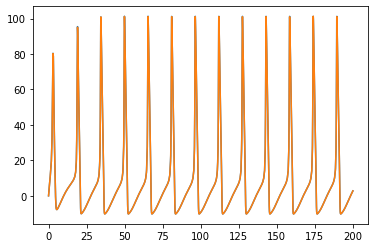

In [30]:
neuron1 = HHModel()
neuron2 = HHModel()

neuron_connection = ShortCircuit([neuron1, neuron2])

T = 200
trange = (0, T)

I0 = 8
iapp1 = lambda t: I0
iapp2 = lambda t: 2*I0

x01 = [0,0,0,0]
x02 = x01 + [0,0,0]

sol1 = neuron1.simulate(trange, x01, iapp1)
sol2 = neuron_connection.simulate(trange, x02, iapp2)

plt.figure()
plt.plot(sol1.t, sol1.y[0])
plt.plot(sol2.t, sol2.y[0])
plt.show()

We see that the interconnection seems to work - we get the same behavior with the two-neuron interconnection as with the original neuron!

Note that we need to pass an initial state vector of the appropriate size: in this case we had two neurons with six gating variable dynamics in total, and a single membrane voltage.

### Setting the parameters of the second neuron

Let's see now if by appropriately changing the parameters of the second neuron, we can get the interconnection to burst. To do this, we can follow the underlying principles discussed for the Aplysia R-15 model.

#### Turning off sodium inactivation

To start, we can fix the sodium inactivation to $1$ so that it resembles more the calcium current with a single activation variable. This can be done by setting $\beta_h(V) = 0$ since then the $h$ equation becomes

\begin{equation}
\dot{h} = \alpha_h(V) (1 - h)
\end{equation}

so that the steady-state value is $h = 1$ for all $V$. We can do this by setting the parameter `bA` of the gating variable to `0`.

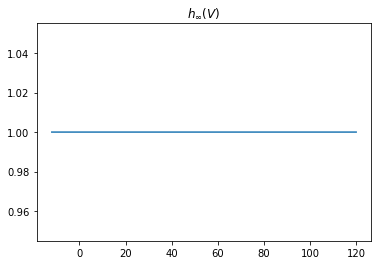

In [31]:
# Set h = 1
V = np.arange(neuron1.Ek, neuron1.Ena, 0.1)

neuron2.h.bA = 0

plt.figure()
plt.title("$h_{\infty}(V)$")
plt.plot(V, neuron2.h.inf(V))
plt.show()

#### Shifting the steady-state functions of $m$ and $n$

Now, let's shift the steady-state functions of sodium and potassium activation to a lower voltage range, so that the threshold voltage is also shifted as a result. Remember that 

\begin{equation}
m_{\infty}(V) = \frac{\alpha_m(V)}{\alpha_m(V) + \beta_m(V)}
\end{equation}

so that adding the same voltage shift to $\alpha_m(V + \delta V)$ and $\beta_m(V + \delta V)$ functions will shift $m_{\infty}(V + \delta V)$ by the same amount.

We can do that by changing the parameter $V_h$ of the $m$ and $n$ variables, which represents the half-activation voltage. We need to change this parameter for both $\alpha(V)$ and $\beta(V)$ functions, so the corresponding variable names are `aVh` and `bVh`. We can then apply this to both $m$ and $n$ gating variables.

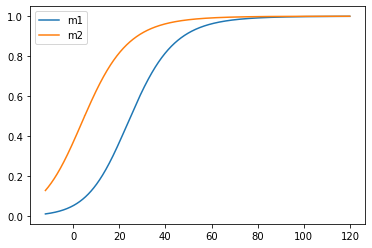

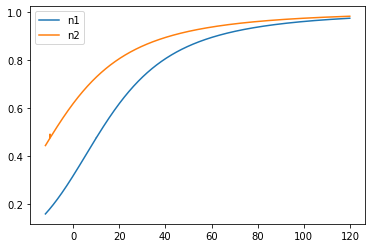

In [32]:
# Shift m and n for neuron 2
vshift = 20

# Shift m
neuron2.m.aVh = neuron1.m.aVh - vshift
neuron2.m.bVh = neuron1.m.bVh - vshift

# Shift n
neuron2.n.aVh = neuron1.n.aVh - vshift
neuron2.n.bVh = neuron1.n.bVh - vshift

plt.figure()
plt.plot(V, neuron1.m.inf(V), label = 'm1')
plt.plot(V, neuron2.m.inf(V), label = 'm2')
plt.legend()
plt.show()

plt.figure()
plt.plot(V, neuron1.n.inf(V), label = 'n1')
plt.plot(V, neuron2.n.inf(V), label = 'n2')
plt.legend()
plt.show()

#### Scaling the time constants of $m$ and $n$

The changes we have done so far had no effect on the timescales of the gating variables $m$ and $n$ and purely affected the steady-state functions. Let's now scale the time constants of the activation variables so that they activate more slowly compared to the original Hodgkin-Huxley currents. Remember that the time constant functions are defined as

\begin{equation}
\tau(V) = \frac{1}{\alpha(V) + \beta(V)}
\end{equation}

so that for example multiplying both $\alpha(V)$ and $\beta(V)$ by $0.1$ will make the time constant $10$ times larger.

We can again do this by scaling the gain constants of the $\alpha(V)$ and $\beta(V)$ functions, represented by the parameters `aA` and `bA` within the gating variables.

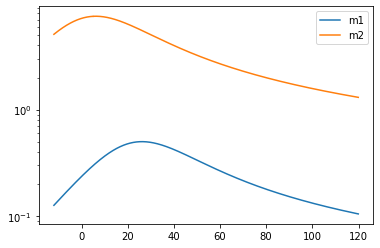

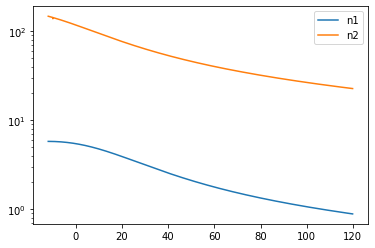

In [24]:
# Scaling the time constants for m and n in neuron 2
t_scale1 = 15
t_scale2 = 30

# Scale the timescale for neuron 2 m variable
neuron2.m.aA = neuron1.m.aA / t_scale1
neuron2.m.bA = neuron1.m.bA / t_scale1

# Scale the timescale for neuron 2 n variable
neuron2.n.aA = neuron1.n.aA / t_scale2
neuron2.n.bA = neuron1.n.bA / t_scale2

plt.figure()
plt.semilogy(V, neuron1.m.tau(V), label = 'm1')
plt.semilogy(V, neuron2.m.tau(V), label = 'm2')
plt.legend()
plt.show()

plt.figure()
plt.semilogy(V, neuron1.n.tau(V), label = 'n1')
plt.semilogy(V, neuron2.n.tau(V), label = 'n2')
plt.legend()
plt.show()

#### Setting the maximal conductances and reversal potentials

Finally, we need to change the maximal conductance parameters, as well as the reversal potentials.

Firstly, we can set the maximal conductance of the leak to $g_l = 0$ since the leak current can be solely provided by the first neuron. Secondly, we can set the reversal potential for the sodium current to be higher, so that it reflects the calcium reversal potential for which $E_{Ca} > E_{Na}$. For the potassium current, we keep the same reversal potential as we are trying to emulate a slow *potassium* current.

The maximal conductance parameters of the sodium and potassium we can use as the control variables in order to tune the bursting oscillation.

In [33]:
# Turn off leak current for neuron 2 
neuron2.gl = 0

# Set reversal potential for neuron 2 sodium to calcium reversal
neuron2.Ena = 200

# Change maximal conductances of sodium and potassium for neuron 2
neuron2.gna = 1
neuron2.gk = 3

#### Simulating the interconnection

Let's now look at how the system behaves over time. We can go back to the previous sections and change the parameters to see how it changes the oscillating behavior.

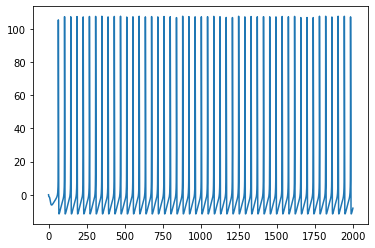

In [34]:
# Simulate HH short-circuit

T = 2000
t = (0, T)

I0 = -5
iapp = lambda t: I0

x0 = [0,0,0,0,0,0,0]

sol = neuron_connection.simulate(t, x0, iapp)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

We should now observe that the interconnected system exhibits intrinsic bursting! You can try changing the parameters of the two slow currents in order to see how they affect the bursting behavior, as well as try obtaining different types of bursting waveforms.

### Post-inhibitory rebound

An important consequence of the internal burst-generating dynamics is what is called a **post-inhibitory rebound** (PIR). This is a phenomenon where an initially silent neuron can fire a transient burst of spikes after a prolonged period of hyperpolarization. This mechanism is fundamental for the generation of sustained oscillations in half-center oscillators, where mutually inhibiting neurons hyperpolarize each other as a result of firing a burst of spikes.

Let's see how our model behaves in response to a long hyperpolarizing pulse:

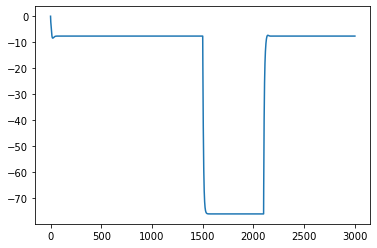

In [38]:
# Post-inhibitory rebound

def pulse(t, t_start, t_length, mag):
    I = (t>=t_start)*mag - (t>=(t_start+t_length))*mag
    return I

T = 3000
t = (0, T)

I0 = -6
pulse_mag = 2

def Iapp(t):
    t_start = T / 2
    t_length = T / 5
    return I0 - pulse(t, t_start, t_length, pulse_mag)

x0 = [0,0,0,0,0,0,0]

sol = neuron_connection.simulate(t, x0, Iapp)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

We can try different values of the pulse magnitude - you should notice that for a small pulse the system will generate a small rebound bump. In this case, the rebound is not large enough to activate the fast spiking dynamics and the system goes back to rest after the transient. However, if the pulse is large enough the rebound will move the system through the spiking regime before returning to rest, thus creating a transient burst. We can use the post-inhibitory rebound as the basic mechanism for generating bursting oscillations in inhibitory networks.

## Next step: bursting through interconnection of NeuroDyn circuits

The procedure discussed so far can be used as a first step to designing more complex neuronal behaviors in NeuroDyn hardware. By using the fitting procedures described in the **NeuroDyn Python model** notebook, we can first design an interconnection of Hodgkin-Huxley models that would give us the desired behavior of the system, and then translate the Hodgkin-Huxley parameters to the parameters that can be set within the hardware.

The additional challenge here is ensuring that the parameters can be fitted within the physical constraints. Due to this, we might find that certain regimes may not be directly translated to the NeuroDyn equations. Importantly, remember that the current $I_{master}$ in NeuroDyn determines the effective scale of the maximal conductances and $\alpha$ and $\beta$ coefficients. By decreasing the $I_{master}$ of a neuron, its time-scale is also effictively decreased, and we can use this to design the slower neuron.

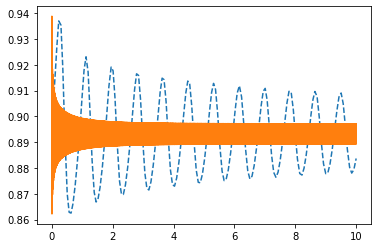

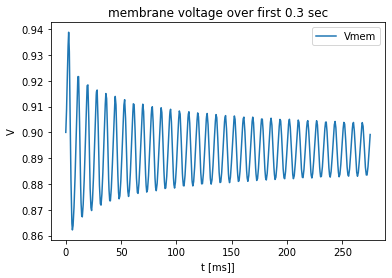

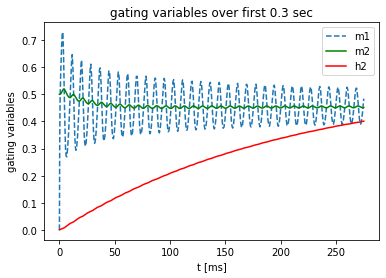

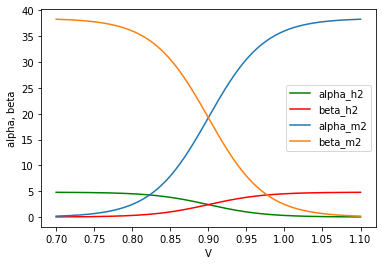

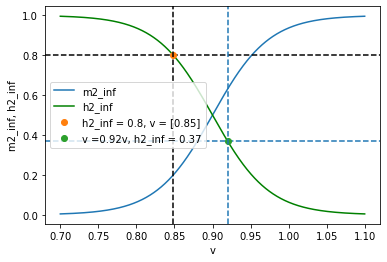

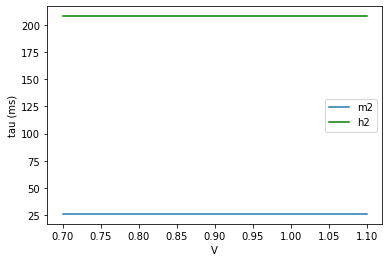

In [75]:
import matplotlib.pyplot as plt
from cb_models_old import HHModel, NeuroDynModel, ShortCircuit

# **Ignore overflow warnings**
import numpy as np
d = np.seterr(all="ignore")
import math
import warnings
warnings.filterwarnings('ignore')

V_ref = 0.9
I_master1 = 40e-9
I_ref1 = 0.4e-9
I_voltage1 = 3.0e-6

dg1 = np.array([512, 1023, 32])   # [gna, gk, gl]
dE1 = np.array([1023, -1023, 400])   # [Ena, Ek, El]

dIb_m = np.array([[0, 0, 0, 256, 0, 0, 0],             # alpha_m
                     [0, 0, 0, 256, 0, 0, 0]])         # beta_m
dIb_h = np.array([[0, 0, 0, 32, 0, 0, 0],              # alpha_h
                    [0, 0, 0, 32, 0, 0, 0]])           # beta_h
dIb_n = np.array([[0, 0, 0, 32, 0, 0, 0],              # alpha_n
                    [0, 0, 0, 32, 0, 0, 0]])           # beta_n
dIb1 = [dIb_m, dIb_h, dIb_n]

#ND = NeuroDynModel(dg1, dE1, dIb1, V_ref, I_voltage/20, I_master/20, I_ref/20)
ND1 = NeuroDynModel(dg1, dE1, dIb1, V_ref, I_voltage1/20, I_master1/20, I_ref1/20, capacitance_scaling = 0.5)


I_master2 = 0.4e-9
I_ref2 = 0.004e-9
I_voltage2 = 3.0e-6

dg2 = np.array([512, 1023, 32])   # [gna, gk, gl]
dE2 = np.array([1023, -1023, 400])   # [Ena, Ek, El]

dIb_m = np.array([[0, 0, 0, 256, 0, 0, 0],             # alpha_m      -- m gate is akways open
                     [0, 0, 0, 256, 0, 0, 0]])         # beta_m
dIb_h = np.array([[0, 0, 0, 32, 0, 0, 0],              # alpha_h
                    [0, 0, 0, 32, 0, 0, 0]])           # beta_h
dIb_n = np.array([[0, 0, 0, 32, 0, 0, 0],              # alpha_n       -- n gate is always closed
                    [0, 0, 0, 32, 0, 0, 0]])           # beta_n
dIb2 = [dIb_m, dIb_h, dIb_n]

ND = NeuroDynModel(dg2, dE2, dIb2, V_ref, I_voltage2/20, I_master2/20, I_ref2/20)
ND2 = NeuroDynModel(dg2, dE2, dIb2, V_ref, I_voltage2/20, I_master2/20, I_ref2/20, capacitance_scaling = 0.5)

neuron_connection = ShortCircuit([ND1, ND2])

T = 10
trange = (0, T)

I0 = 0e-12
iapp1 = lambda t: I0
iapp2 = lambda t: I0

x01 = [0.9,0,0,0]
x02 = x01 + [0.5,0,0]

sol1 = ND.simulate(trange, x01, iapp1)
sol2 = neuron_connection.simulate(trange, x02, iapp2)

plt.figure()
plt.plot(sol1.t, sol1.y[0],'--')
plt.plot(sol2.t, sol2.y[0])
plt.show()


# Interpolate membrane voltage

ts = 1e-5   #spacing between samples
fs = 1/ts   # sampling frequency
N = int(T*fs)   # number of samples
#print('Number of sample points:',N)
t_int = np.linspace(0,T,N)
   
from scipy.interpolate import interp1d    
f1 = interp1d(sol2.t, sol2.y[0])
f2 = interp1d(sol2.t, sol2.y[1])
f3 = interp1d(sol2.t, sol2.y[2])
f4 = interp1d(sol2.t, sol2.y[3])
f5 = interp1d(sol2.t, sol2.y[4])
f6 = interp1d(sol2.t, sol2.y[5])

v_int = f1(t_int)
m1_int = f2(t_int)
h1_int = f3(t_int)
n1_int = f4(t_int)
m2_int = f5(t_int)
h2_int = f6(t_int)

#Na_int = np.multiply(np.multiply(m_int,m_int),np.multiply(m_int,h_int))
#K_int = np.multiply(np.multiply(n_int,n_int),np.multiply(n_int,n_int))

#plt.plot(sol.t*1000, sol.y[0], 'o', t_int*1000, v_int, '-')
#plt.legend(['data', 'linear interpolation'], loc='best')
#plt.xlabel('t (msec)')
#plt.ylabel('V')
#plt.title('True and Interpolated data')
#plt.show()

t_start = 0.0
t_end = 0.275

plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, v_int[int(t_start*fs):int(t_end*fs)], '-')
plt.legend(['Vmem'], loc='best')
plt.xlabel('t [ms]]')
plt.ylabel('V')
plt.title('membrane voltage over first 0.3 sec')
plt.show()

plt.figure()
plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, m1_int[int(t_start*fs):int(t_end*fs)],'--')
plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, m2_int[int(t_start*fs):int(t_end*fs)],'g')
plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, h2_int[int(t_start*fs):int(t_end*fs)],'r')
#plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, n1_int[int(t_start*fs):int(t_end*fs)])
plt.legend(['m1', 'm2', 'h2'], loc='best')
plt.xlabel('t [ms]')
plt.ylabel('gating variables')
plt.title('gating variables over first 0.3 sec')
plt.show()


v = np.linspace(0.7,1.1,1000)
h2_inf = np.divide(ND2.h.alpha(v),(ND2.h.alpha(v) + ND2.h.beta(v)))
tau_h2 = np.divide(1,(ND2.h.alpha(v) + ND2.h.beta(v)))
m2_inf = np.divide(ND2.m.alpha(v),(ND2.m.alpha(v) + ND2.m.beta(v)))
tau_m2 = np.divide(1,(ND2.m.alpha(v) + ND2.m.beta(v)))


plt.figure()
plt.plot(v,ND2.h.alpha(v),'g')
plt.plot(v,ND2.h.beta(v),'r')
plt.plot(v,ND2.m.alpha(v))
plt.plot(v,ND2.m.beta(v))
plt.xlabel('V')
plt.ylabel('alpha, beta')
plt.legend(['alpha_h2', 'beta_h2', 'alpha_m2', 'beta_m2'], loc='best')
plt.show()

h_transition = 0.8
vss = 0.92
g1 = []
for i in range(len(h2_inf)):
    g1.append(h_transition)
plt.figure()
plt.plot(v,m2_inf)
plt.plot(v,h2_inf,'g')
#plt.plot(v,n_inf,'r')
plt.axhline(y = h_transition, color = 'k', linestyle = '--')
idx = np.argwhere(np.diff(np.sign(g1 - h2_inf))).flatten()
plt.plot(v[idx], h2_inf[idx], 'o')
plt.axvline(x = v[idx], color = 'k', linestyle = '--')
h_inf_vss = np.interp(vss, v, h2_inf)
plt.axhline(y = h_inf_vss, linestyle = '--')
plt.plot(vss, h_inf_vss, 'o')
plt.axvline(x = vss, linestyle = '--')
plt.xlabel('v')
plt.ylabel('m2_inf, h2_inf')
plt.legend(['m2_inf', 'h2_inf','_','h2_inf = '+str(h_transition)+', v = '+str(np.round(v[idx],2)),'_','_', 'v ='+str(vss)+'v, h2_inf = '+str(np.round(h_inf_vss,2))], loc='best')
plt.show()


plt.figure()
plt.plot(v,tau_m2*1000)
plt.plot(v,tau_h2*1000,'g')
#plt.plot(v,tau_n*1000,'r')
plt.xlabel('V')
plt.ylabel('tau (ms)')
plt.legend(['m2', 'h2'], loc='best')
plt.show()

### Attempt to use h as a neuromodulator for bursting - can include additional currents from a second neuron short circuited to the current neuron

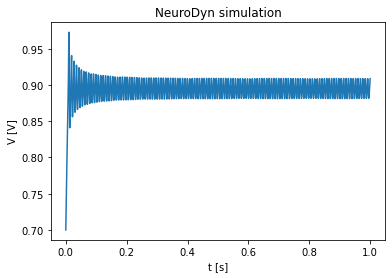

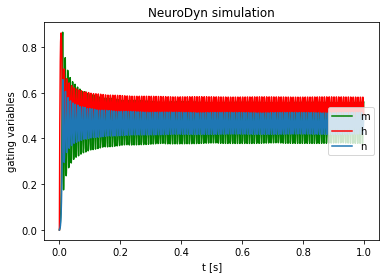

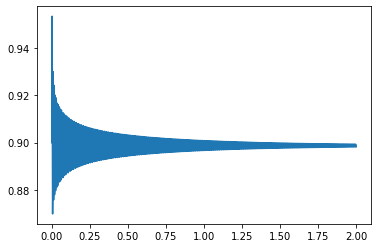

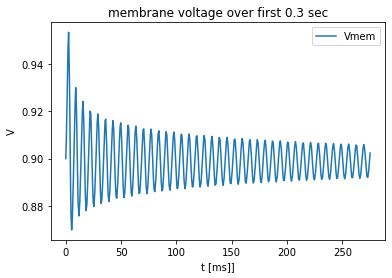

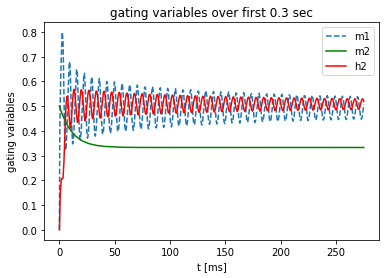

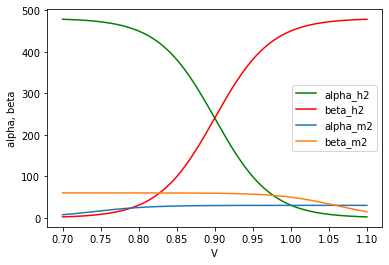

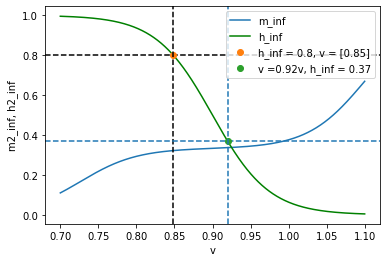

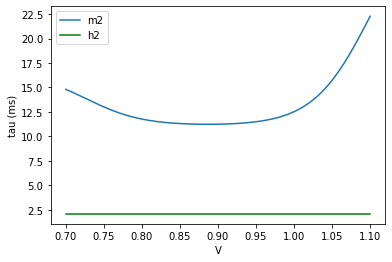

In [20]:
import matplotlib.pyplot as plt
from cb_models_old import HHModel, NeuroDynModel, ShortCircuit

# **Ignore overflow warnings**
import numpy as np
d = np.seterr(all="ignore")
import math
import warnings
warnings.filterwarnings('ignore')

V_ref = 0.9
I_master = 40e-9
I_ref = 0.4e-9
I_voltage = 3.0e-6

dg1 = np.array([512, 1023, 32])   # [gna, gk, gl]
dE1 = np.array([1023, -1023, 400])   # [Ena, Ek, El]

dIb_m = np.array([[0, 0, 0, 256, 0, 0, 0],             # alpha_m
                     [0, 0, 0, 256, 0, 0, 0]])         # beta_m
dIb_h = np.array([[0, 0, 0, 32, 0, 0, 0],              # alpha_h
                    [0, 0, 0, 32, 0, 0, 0]])           # beta_h
#dIb_h = np.array([[0, 0, 0, 0, 0, 0, 0],              # alpha_h
#                    [4, 0, 0, 0, 0, 0, 0]])           # beta_h
dIb_n = np.array([[0, 0, 0, 32, 0, 0, 0],              # alpha_n
                    [0, 0, 0, 32, 0, 0, 0]])           # beta_n
dIb1 = [dIb_m, dIb_h, dIb_n]

ND = NeuroDynModel(dg1, dE1, dIb1, V_ref, I_voltage/20, I_master/20, I_ref/20)
ND1 = NeuroDynModel(dg1, dE1, dIb1, V_ref, I_voltage/20, I_master/20, I_ref/20, capacitance_scaling = 0.5)


dg2 = np.array([512, 0, 0])   # [gna, gk, gl]
dE2 = np.array([1023, -1023, 0])   # [Ena, Ek, El]

dIb_m = np.array([[0, 2, 0, 0, 0, 0, 0],             # alpha_m      -- m gate is akways open
                     [0, 0, 0, 0, 0, 4, 0]])         # beta_m
dIb_h = np.array([[0, 0, 0, 32, 0, 0, 0],              # alpha_h
                    [0, 0, 0, 32, 0, 0, 0]])           # beta_h
#dIb_h = np.array([[0, 0, 0, 0, 0, 0, 0],              # alpha_h
#                    [4, 0, 0, 0, 0, 0, 0]])           # beta_h
dIb_n = np.array([[0, 0, 0, 0, 0, 0, 0],              # alpha_n       -- n gate is always closed
                    [0, 0, 0, 0, 0, 0, 32]])           # beta_n
dIb2 = [dIb_m, dIb_h, dIb_n]

ND2 = NeuroDynModel(dg2, dE2, dIb2, V_ref, I_voltage/20, I_master/20, I_ref/20, capacitance_scaling = 0.5)


T = 1
trange = (0, T)

Iapp = lambda t : 10e-12
sol = ND.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t [s]')
plt.ylabel('V [V]')
plt.title('NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

plt.figure()
plt.xlabel('t [s]')
plt.ylabel('gating variables')
plt.title('NeuroDyn simulation')
plt.plot(sol.t, sol.y[1],'g')
plt.plot(sol.t, sol.y[2],'r')
plt.plot(sol.t, sol.y[3])
plt.legend(['m', 'h', 'n'], loc='center right')
plt.show()

neuron_connection = ShortCircuit([ND1, ND2])

T = 2
trange = (0, T)

I0 = 10e-12
iapp1 = lambda t: I0
iapp2 = lambda t: I0

x01 = [0.9,0,0,0]
x02 = x01 + [0.5,0,0]

sol1 = ND.simulate(trange, x01, iapp1)
sol2 = neuron_connection.simulate(trange, x02, iapp2)

plt.figure()
#plt.plot(sol1.t, sol1.y[0],'--')
plt.plot(sol2.t, sol2.y[0])
plt.show()


# Interpolate membrane voltage

ts = 1e-5   #spacing between samples
fs = 1/ts   # sampling frequency
N = int(T*fs)   # number of samples
#print('Number of sample points:',N)
t_int = np.linspace(0,T,N)
   
from scipy.interpolate import interp1d    
f1 = interp1d(sol2.t, sol2.y[0])
f2 = interp1d(sol2.t, sol2.y[1])
f3 = interp1d(sol2.t, sol2.y[2])
f4 = interp1d(sol2.t, sol2.y[3])
f5 = interp1d(sol2.t, sol2.y[4])
f6 = interp1d(sol2.t, sol2.y[5])

v_int = f1(t_int)
m1_int = f2(t_int)
h1_int = f3(t_int)
n1_int = f4(t_int)
m2_int = f5(t_int)
h2_int = f6(t_int)

#Na_int = np.multiply(np.multiply(m_int,m_int),np.multiply(m_int,h_int))
#K_int = np.multiply(np.multiply(n_int,n_int),np.multiply(n_int,n_int))

#plt.plot(sol.t*1000, sol.y[0], 'o', t_int*1000, v_int, '-')
#plt.legend(['data', 'linear interpolation'], loc='best')
#plt.xlabel('t (msec)')
#plt.ylabel('V')
#plt.title('True and Interpolated data')
#plt.show()

t_start = 0.0
t_end = 0.275

plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, v_int[int(t_start*fs):int(t_end*fs)], '-')
plt.legend(['Vmem'], loc='best')
plt.xlabel('t [ms]]')
plt.ylabel('V')
plt.title('membrane voltage over first 0.3 sec')
plt.show()

plt.figure()
plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, m1_int[int(t_start*fs):int(t_end*fs)],'--')
plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, m2_int[int(t_start*fs):int(t_end*fs)],'g')
plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, h2_int[int(t_start*fs):int(t_end*fs)],'r')
#plt.plot(t_int[int(t_start*fs):int(t_end*fs)]*1000, n1_int[int(t_start*fs):int(t_end*fs)])
plt.legend(['m1', 'm2', 'h2'], loc='best')
plt.xlabel('t [ms]')
plt.ylabel('gating variables')
plt.title('gating variables over first 0.3 sec')
plt.show()


v = np.linspace(0.7,1.1,1000)
h2_inf = np.divide(ND2.h.alpha(v),(ND2.h.alpha(v) + ND2.h.beta(v)))
tau_h2 = np.divide(1,(ND2.h.alpha(v) + ND2.h.beta(v)))
m2_inf = np.divide(ND2.m.alpha(v),(ND2.m.alpha(v) + ND2.m.beta(v)))
tau_m2 = np.divide(1,(ND2.m.alpha(v) + ND2.m.beta(v)))


plt.figure()
plt.plot(v,ND2.h.alpha(v),'g')
plt.plot(v,ND2.h.beta(v),'r')
plt.plot(v,ND2.m.alpha(v))
plt.plot(v,ND2.m.beta(v))
plt.xlabel('V')
plt.ylabel('alpha, beta')
plt.legend(['alpha_h2', 'beta_h2', 'alpha_m2', 'beta_m2'], loc='best')
plt.show()

h_transition = 0.8
vss = 0.92
g1 = []
for i in range(len(h2_inf)):
    g1.append(h_transition)
plt.figure()
plt.plot(v,m2_inf)
plt.plot(v,h2_inf,'g')
#plt.plot(v,n_inf,'r')
plt.axhline(y = h_transition, color = 'k', linestyle = '--')
idx = np.argwhere(np.diff(np.sign(g1 - h2_inf))).flatten()
plt.plot(v[idx], h2_inf[idx], 'o')
plt.axvline(x = v[idx], color = 'k', linestyle = '--')
h_inf_vss = np.interp(vss, v, h2_inf)
plt.axhline(y = h_inf_vss, linestyle = '--')
plt.plot(vss, h_inf_vss, 'o')
plt.axvline(x = vss, linestyle = '--')
plt.xlabel('v')
plt.ylabel('m2_inf, h2_inf')
plt.legend(['m_inf', 'h_inf','_','h_inf = '+str(h_transition)+', v = '+str(np.round(v[idx],2)),'_','_', 'v ='+str(vss)+'v, h_inf = '+str(np.round(h_inf_vss,2))], loc='best')
plt.show()


plt.figure()
plt.plot(v,tau_m2*1000)
plt.plot(v,tau_h2*1000,'g')
#plt.plot(v,tau_n*1000,'r')
plt.xlabel('V')
plt.ylabel('tau (ms)')
plt.legend(['m2', 'h2'], loc='best')
plt.show()

In [23]:
print('steady state voltage: ', v_int[len(v_int)-2])
print('steady state h: ', h2_int[len(h2_int)-2])

steady state voltage:  0.8981917455026677
steady state h:  0.5089677770134987
